In [12]:
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import cv2
from matplotlib import pyplot as plt

from models import DeShadowNet



In [16]:
from test import test
test()

img_dir: data/SRD/test/
img options: {'w': 256, 'h': 256}


100%|██████████| 407/407 [00:10<00:00, 38.75it/s]

RMSE: 25.52017389527117, PSNR: 20.49146842019271, SSIM: 0.6618763177635043, LPIPS: 0.18642207348595674


Inference complete. Result saved to output/result.png
Target image not provided. Metrics not computed.


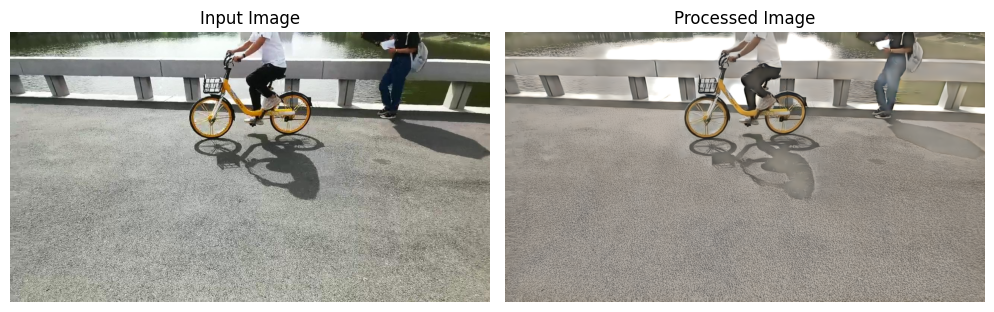

In [54]:
import warnings

warnings.filterwarnings('ignore')

import torch
import matplotlib.pyplot as plt
from accelerate import Accelerator
from torchmetrics.functional import peak_signal_noise_ratio, structural_similarity_index_measure
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
from torchvision.utils import save_image
from torchvision.transforms.functional import to_tensor, to_pil_image
from PIL import Image

from config import Config
from models import *
from utils import *


def single_image_inference(image_path, target_path=None, output_path="result.png"):
    # Load configuration
    opt = Config('config.yml')
    seed_everything(opt.OPTIM.SEED)

    # Initialize Accelerator
    accelerator = Accelerator()
    device = accelerator.device

    # Load metrics
    criterion_lpips = LearnedPerceptualImagePatchSimilarity(net_type='alex', normalize=True).to(device)

    # Load the model
    model = DeShadowNet()
    load_checkpoint(model, opt.TESTING.WEIGHT)  # Load pre-trained weights
    model = accelerator.prepare(model)
    model.eval()

    # Load and preprocess the input image
    input_image = Image.open(image_path).convert('RGB')
    input_tensor = to_tensor(input_image).unsqueeze(0).to(device)  # Normalize to [0, 1]

    # Forward pass through the model
    with torch.no_grad():
        result_tensor = model(input_tensor)

    # Save the output image
    save_image(result_tensor, output_path)
    print(f"Inference complete. Result saved to {output_path}")

    # Calculate metrics if target image is provided
    psnr, ssim, lpips = None, None, None
    if target_path:
        target_image = Image.open(target_path).convert('RGB')
        target_tensor = to_tensor(target_image).unsqueeze(0).to(device)

        psnr = peak_signal_noise_ratio(result_tensor, target_tensor, data_range=1).item()
        ssim = structural_similarity_index_measure(result_tensor, target_tensor, data_range=1).item()
        lpips = criterion_lpips(result_tensor, target_tensor).item()

        print(f"PSNR: {psnr:.2f}, SSIM: {ssim:.3f}, LPIPS: {lpips:.3f}")
    else:
        print("Target image not provided. Metrics not computed.")

    # Convert tensors to PIL images for visualization
    result_image = to_pil_image(result_tensor.squeeze(0).cpu())
    target_image = Image.open(target_path).convert('RGB') if target_path else None

    # Plot the images using matplotlib
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(input_image)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(result_image)
    plt.title("Processed Image")
    plt.axis("off")

    if target_image:
        plt.subplot(1, 3, 3)
        plt.imshow(target_image)
        plt.title("Target Image")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    # Specify paths
    # input_image_path = "data/SRD/test/shadow/_MG_6598.jpg"
    input_image_path = "data/test/test_3.jpg"
    target_image_path = None  # Optional
    output_image_path = "output/result.png"

    # Run single image inference
    single_image_inference(input_image_path, target_image_path, output_image_path)


Inference completed in 7.86 seconds.
Target image not provided. Metrics not computed.


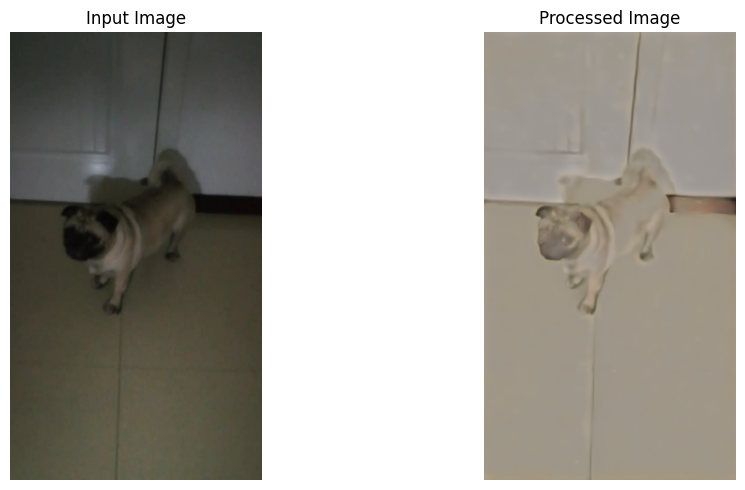

In [69]:
# cpu inference
import time

def single_image_inference_cpu(image_path, target_path=None, output_path=None):
    # Load configuration
    opt = Config('config.yml')
    seed_everything(opt.OPTIM.SEED)

    # Set device to CPU
    device = torch.device('cpu')

    # Load metrics
    criterion_lpips = LearnedPerceptualImagePatchSimilarity(net_type='alex', normalize=True).to(device)

    # Load the model
    model = DeShadowNet()
    
    load_checkpoint(model, opt.TESTING.WEIGHT)  # Load pre-trained weights
    # Quantize for CPU
    model = torch.quantization.quantize_dynamic(model, {torch.nn.Linear, torch.nn.Conv2d}, dtype=torch.qint8)

    model = model.to(device)  # Move the model to CPU
    model.eval()

    start_time = time.time()

    # Load and preprocess the input image
    input_image = Image.open(image_path).convert('RGB')
    input_tensor = to_tensor(input_image).unsqueeze(0).to(device)  # Normalize to [0, 1]

    # Forward pass through the model
    with torch.no_grad():
        result_tensor = model(input_tensor)

    # Save the output image
    if output_path:
        save_image(result_tensor, output_path)
        print(f"Inference complete. Result saved to {output_path}")

    elapsed_time = time.time() - start_time
    print(f"Inference completed in {elapsed_time:.2f} seconds.")

    # Calculate metrics if target image is provided
    psnr, ssim, lpips = None, None, None
    if target_path:
        target_image = Image.open(target_path).convert('RGB')
        target_tensor = to_tensor(target_image).unsqueeze(0).to(device)

        psnr = peak_signal_noise_ratio(result_tensor, target_tensor, data_range=1).item()
        ssim = structural_similarity_index_measure(result_tensor, target_tensor, data_range=1).item()
        lpips = criterion_lpips(result_tensor, target_tensor).item()

        print(f"PSNR: {psnr:.2f}, SSIM: {ssim:.3f}, LPIPS: {lpips:.3f}")
    else:
        print("Target image not provided. Metrics not computed.")

    # Convert tensors to PIL images for visualization
    result_image = to_pil_image(result_tensor.squeeze(0).cpu())
    target_image = Image.open(target_path).convert('RGB') if target_path else None

    # Plot the images using matplotlib
    if not output_path:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(input_image)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(result_image)
        plt.title("Processed Image")
        plt.axis("off")

        if target_image:
            plt.subplot(1, 3, 3)
            plt.imshow(target_image)
            plt.title("Target Image")
            plt.axis("off")

        plt.tight_layout()
        plt.show()


if __name__ == '__main__':
    # Specify paths
    input_image_path = "data/test/test_1.jpg"
    target_image_path = None  # Optional
    # output_image_path = "output/result.png"
    output_image_path = None

    # Run single image inference

    single_image_inference_cpu(input_image_path, target_image_path, output_image_path)


In [ ]:
import torch.onnx
import torch
from models import DeShadowNet
from torch.autograd import Variable

model = DeShadowNet()
load_checkpoint(model, "checkpoints/SRD_epoch_86.pth")  # Load pre-trained weights

model.eval()

# Create a dummy input for the model
dummy_input = torch.randn(1, 3, 256, 256)  # Adjust dimensions based on your model's expected input

# Export the model to ONNX format
onnx_file = "output/deshadow_model.onnx"
torch.onnx.export(model, dummy_input, onnx_file, opset_version=11)


In [75]:
import onnxruntime as ort
import numpy as np
from PIL import Image
from torchvision.transforms.functional import to_tensor, resize

# Load the ONNX model
onnx_model_path = "output/deshadow_model.onnx"
sess = ort.InferenceSession(onnx_model_path, providers=["CPUExecutionProvider"])

# Load and preprocess image
input_image = Image.open("data/test/test_1.jpg").convert("RGB")
input_tensor = to_tensor(resize(input_image, (256, 256)))  # Resize and convert to tensor
input_tensor = input_tensor.numpy()  # Convert tensor to NumPy array
input_tensor = np.expand_dims(input_tensor, axis=0)  # Add batch dimension

# Run inference
inputs = {sess.get_inputs()[0].name: input_tensor}
onnx_output = sess.run(None, inputs)

# Convert the result back to a tensor
output_tensor = torch.from_numpy(onnx_output[0])

# Post-process and save the result
output_tensor = output_tensor.clamp(0, 1)  # Ensure values are within [0, 1]
save_image(output_tensor, "output/result_onnx.jpg")